In [41]:
from collections import defaultdict
from dataclasses import dataclass
from functools import cache
import random

import torch
import torch.nn.functional as F

from evo import Evo
from evo.generation import Generator

from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score

# Setup

In [2]:
# run models on GPU if GPU node is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# download the model
evo_model = Evo("evo-1.5-8k-base")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# extract torch modules
tokenizer = evo_model.tokenizer
model = evo_model.model.to(device)

In [5]:
# create a generator object
generator_hot = Generator(model, tokenizer, temperature=1.)
generator_warm = Generator(model, tokenizer, temperature=0.5)
generator_cold = Generator(model, tokenizer, temperature=0.001)

# Dummy example

We will test calling the generator function to ensure that everything is working correctly.

In [77]:
# generate 10 characters after a context of "ACGT"
torch.manual_seed(42)
test_result = generator_hot.generate(device="cuda", input_string="ACGT", num_tokens=10)

In [7]:
# output tokens
tokens = test_result[0]
print(tokens)
print(tokens.shape)
print(tokenizer.detokenize(tokens.squeeze()))

tensor([[67, 71, 65, 71, 71, 84, 71, 67, 71, 67]], device='cuda:0')
torch.Size([1, 10])
CGAGGTGCGC


In [8]:
# output scores
scores = test_result[1]
print(scores)
print(scores.shape)

tensor([[[ -7.7812, -22.2500, -22.2500,  ..., -22.2500, -22.2500, -22.1250],
         [ -8.4375, -22.3750, -22.3750,  ..., -22.3750, -22.3750, -22.3750],
         [ -9.1250, -22.6250, -22.5000,  ..., -22.5000, -22.5000, -22.5000],
         ...,
         [ -8.8125, -22.5000, -22.5000,  ..., -22.5000, -22.5000, -22.5000],
         [ -9.1250, -22.6250, -22.5000,  ..., -22.5000, -22.6250, -22.5000],
         [ -8.6250, -22.6250, -22.5000,  ..., -22.5000, -22.6250, -22.5000]]],
       device='cuda:0')
torch.Size([1, 10, 512])


In [9]:
# get logits for ACGT tokens
acgt_logits = scores[0,:,(65,67,71,84)]
print(acgt_logits)

tensor([[-0.7070,  0.0884, -0.2197, -0.3105],
        [-0.4316, -0.2754,  0.2910, -0.7852],
        [-0.1128, -0.2412, -0.3125, -0.4844],
        [-0.6602, -0.0869, -0.0767, -0.3848],
        [-0.5625,  0.2441,  0.1895, -1.1016],
        [-0.1846, -0.1523, -0.5742, -0.2773],
        [-1.1016,  0.4883,  0.0786, -0.7500],
        [-0.4609,  0.1592,  0.0967, -1.0312],
        [-0.5586, -0.4609, -0.2832,  0.0679],
        [-1.2656,  0.7148,  0.0053, -0.7695]], device='cuda:0')


In [10]:
# calculate probabilities with softmax
acgt_probs = torch.softmax(acgt_logits, dim=-1)

In [11]:
# create a sample sequence for comparison
sample_seq = "CCTCGATGAG" # "GGAGCTACTC"
sample_tokens = torch.tensor(tokenizer.tokenize(sample_seq))

In [12]:
# get one-hot matrix for metric calculation
sample_probs = F.one_hot(sample_tokens.to(torch.int64))[:,(65,67,71,84)]
sample_probs

tensor([[0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0]])

In [13]:
# calculate AUROC
roc_auc_score(sample_probs, acgt_probs.to("cpu"))

0.5706845238095238

In [14]:
# calculate "correct" predictions
acgt_probs.argmax(dim=1).to("cpu") == sample_probs.argmax(dim=1)

tensor([ True, False, False, False, False, False, False, False, False, False])

The generator works. Its output is a sequence of predictions and logits for the next k characters. We will use that information to calculate metrics.

# Utils

We will define some functions that will be used in the analysis.

In [15]:
@dataclass
class SeqStats:
    """Dataclass for storing generation parameters and metrics."""
    biotype: str
    index: int
    mock: bool
    k_fit: int
    k_test: int
    correctness: float
    auroc: float
    auprc: float

In [16]:
@cache
def get_forward_stats(seq_fit, seq_test, generator, *, biotype="unknown", index=0, mock=False, seed=None) -> SeqStats:
    """Generate a sequence and calculate metrics."""
    k_fit = len(seq_fit)
    k_test = len(seq_test)

    if seed is not None:
        torch.manual_seed(seed)
    test_tokens = torch.tensor(tokenizer.tokenize(seq_test))
    gen_tokens, scores, _ = generator.generate("cuda", input_string=seq_fit, num_tokens=k_test,
                                               cached_generation=True)
    
    correct = gen_tokens.to("cpu") == test_tokens
    correctness = correct.to(torch.float).mean().item()

    test_probs = F.one_hot(test_tokens.to(torch.int64))[:,(65,67,71,84)]
    gen_acgt_logits = scores[0,:,(65,67,71,84)]
    gen_acgt_probs = torch.softmax(gen_acgt_logits, dim=-1).to("cpu")
    auroc = roc_auc_score(test_probs, gen_acgt_probs, average="weighted")

    auprc = average_precision_score(test_probs, gen_acgt_probs, average="weighted")

    return SeqStats(biotype=biotype,
                    index=index,
                    mock=mock,
                    k_fit=k_fit,
                    k_test=k_test,
                    correctness=correctness,
                    auroc=auroc,
                    auprc=auprc)

In [17]:
def forward_from_fasta(path, /, k_fit, k_test, generator, *, biotype="unknown", index=0, mock=False, seed=None) -> SeqStats:
    """Generate a sequence from a FASTA file and calculate metrics."""
    with open(path, "rt") as f:
        seqs = SeqIO.parse(f, "fasta")
        seq = next(seqs)

    if len(seq) < k_fit + k_test:
        raise ValueError(f"Sequence of length {len(seq)} is too short to provide context length {k_fit} and generation length {k_test}!")
    
    seq_fit = str(seq.seq)[:k_fit]
    seq_test = str(seq.seq)[k_fit:k_fit+k_test]
    return get_forward_stats(seq_fit, seq_test, generator=generator, biotype=biotype, index=index, mock=mock, seed=seed)

In [18]:
def generate_mock(original_seq, new_length, seed=None):
    """Generate a new DNA sequence with the same nucleotide frequencies as the original sequence."""
    # Convert to uppercase and count valid nucleotides
    counts = defaultdict(int)
    valid_nucleotides = {'A', 'T', 'C', 'G'}
    total = 0
    for char in original_seq.upper():
        if char in valid_nucleotides:
            counts[char] += 1
            total += 1
    
    if total == 0:
        raise ValueError("Original sequence contains no valid nucleotides (A, T, C, G).")
    
    # Prepare nucleotides and their corresponding weights (counts)
    nucleotides = []
    weights = []
    for nuc in ['A', 'T', 'C', 'G']:
        if counts[nuc] > 0:
            nucleotides.append(nuc)
            weights.append(counts[nuc])
    
    # Generate the new sequence using the calculated weights
    if seed is not None:
        random.seed(seed)
    new_sequence = ''.join(random.choices(nucleotides, weights=weights, k=new_length))
    return new_sequence

In [37]:
def mock_from_fasta(path, context_len, new_len, seed=None):
    """Generate a mock sequence with nucleotide probabilities from a FASTA file."""
    with open(path, "rt") as f:
        seqs = SeqIO.parse(f, "fasta")
        seq = next(seqs)
    return generate_mock(seq[:context_len], new_len, seed=seed)

# Real sequences

In [19]:
# extract context and target sequences from a FASTA file
with open("seqs/cds_1.fa", "rt") as f:
    seqs = SeqIO.parse(f, "fasta")
    seq = next(seqs)
seq_fit = seq.seq[:2000]
seq_test = seq.seq[2000:2100]
print(seq_fit)
print()
print(seq_test)

ATGTCGGCGCCGTCGGAGGAGGAGGAGTACGCGCGGCTGGTGATGGAGGCGCAGCCGGAGTGGCTGCGCGCCGAGGTGAAGCGGCTGTCCCACGAGCTGGCCGAGACCACGCGTGAGAAGATCCAGGCGGCCGAGTACGGGCTGGCGGTGCTCGAGGAGAAGCACCAGCTCAAGCTGCAGTTCGAGGAGCTCGAGGTGGACTATGAGGCTATCCGCAGCGAGATGGAGCAGCTCAAGGAGGCCTTTGGACAAGCACACACAAACCACAAGAAGGTGGCTGCTGACGGAGAGAGCCGGGAGGAGAGCCTGATCCAGGAGTCGGCCTCCAAGGAGCAGTACTACGTGCGGAAGGTGCTAGAGCTGCAGACGGAGCTGAAGCAGTTGCGCAATGTCCTCACCAACACGCAGTCGGAGAATGAGCGCCTGGCCTCTGTGGCCCAGGAGCTGAAGGAGATCAACCAGAATGTGGAGATCCAGCGTGGCCGCCTGCGGGATGACATCAAGGAGTACAAATTCCGGGAAGCTCGTCTGCTGCAGGACTACTCGGAACTGGAGGAGGAGAACATCAGCCTGCAGAAGCAAGTGTCTGTGCTCAGACAGAACCAGGTGGAGTTTGAGGGCCTCAAGCATGAGATCAAGCGTCTGGAGGAGGAGACCGAGTACCTCAACAGCCAGCTGGAGGATGCCATCCGCCTCAAGGAGATCTCAGAGCGGCAGCTGGAGGAGGCGCTGGAGACCCTGAAGACGGAGCGCGAACAGAAGAACAGCCTGCGCAAGGAGCTGTCACACTACATGAGCATCAATGACTCCTTCTACACCAGCCACCTGCATGTCTCGCTGGATGGCCTCAAGTTCAGTGACGATGCTGCCGAGCCCAACAACGATGCCGAGGCCCTGGTCAATGGCTTTGAGCACGGCGGCCTGGCCAAGCTGCCACTGGACAACAAGACCTCCACGCCCAAGAAGGAGGGCCTCGCACCGCCCTCCCCCAGCCTCGTCT

In [20]:
# generate and calculate metrics
get_forward_stats(str(seq_fit), str(seq_test), generator=generator_hot, seed=42)

SeqStats(biotype='unknown', index=0, mock=False, k_fit=2000, k_test=100, correctness=0.3499999940395355, auroc=0.6482344381677129, auprc=0.3903479748502978)

In [21]:
stats = []

In [22]:
# same thing but with the high level function
cds_stats = forward_from_fasta("seqs/cds_1.fa", 1000, 100, generator=generator_hot, biotype="CDS", index=0, seed=42)
stats.append(cds_stats)
cds_stats

SeqStats(biotype='CDS', index=0, mock=False, k_fit=1000, k_test=100, correctness=0.25999999046325684, auroc=0.524695465321328, auprc=0.32883592479653073)

In [23]:
# same for intron sequence
intron_stats = forward_from_fasta("seqs/intron_1.fa", 1000, 100, generator=generator_hot, biotype="intron", index=0, seed=42)
stats.append(intron_stats)

In [24]:
# same for intergenic sequence
intergenic_stats = forward_from_fasta("seqs/intergenic_1.fa", 1000, 100, generator=generator_hot, biotype="intergenic", index=0, seed=42)
stats.append(intergenic_stats)

In [25]:
# convert to Pandas for plotting
stats_df = pd.DataFrame(stats)

In [26]:
stats_df

,biotype,index,mock,k_fit,k_test,correctness,auroc,auprc
0,CDS,0,False,1000,100,0.26,0.524695,0.328836
1,intron,0,False,1000,100,0.28,0.495785,0.306268
2,intergenic,0,False,1000,100,0.23,0.504251,0.301594


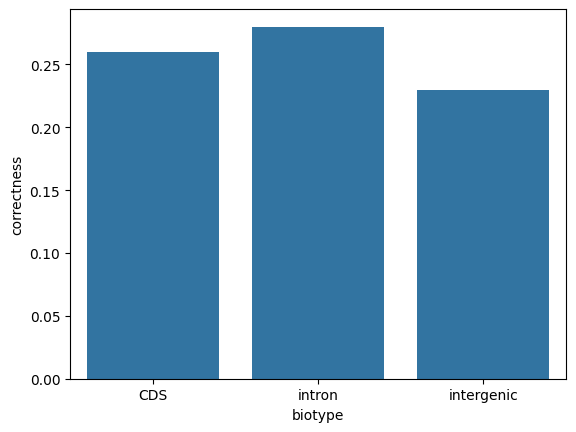

In [27]:
# plot correctness
ax = sns.barplot(data=stats_df, x="biotype", y="correctness")

This doesn't quite look right. The high-temperature generator might be sensitive to the seed. We need to investigate. 

## Check what is going on with seeds

Temperature can have a strong influence on the generation, especially where the logits are close. The seed also has an influence on the outcome. We will evaluate how the metrics behave with 3 different temperature values (1, 0.5, 0.001) and 5 random seeds.

In [28]:
# these are 5 random numbers from 1-1000 generated with the Google RNG widget
# you have to trust me on this
seeds = [45, 908, 380, 870, 409]

In [29]:
seed_stats_hot = []

In [78]:
# calculate metrics for each seed
for seed in seeds:
    seed_stats_hot.append(forward_from_fasta("seqs/cds_1.fa", 1000, 100, generator=generator_hot, biotype="CDS", index=0, seed=seed))

In [79]:
# make a data frame for easier inspection
seed_df_hot = pd.DataFrame(seed_stats_hot)
seed_df_hot["seed"] = seeds

ValueError: Length of values (5) does not match length of index (10)

In [32]:
seed_df_hot

,biotype,index,mock,k_fit,k_test,correctness,auroc,auprc,seed
0,CDS,0,False,1000,100,0.35,0.666847,0.425155,45
1,CDS,0,False,1000,100,0.33,0.538889,0.319273,908
2,CDS,0,False,1000,100,0.26,0.542278,0.297104,380
3,CDS,0,False,1000,100,0.38,0.671378,0.437344,870
4,CDS,0,False,1000,100,0.36,0.665898,0.425186,409


In [33]:
# same for temperature 0.5
seed_stats_warm = []
for seed in seeds:
    seed_stats_warm.append(forward_from_fasta("seqs/cds_1.fa", 1000, 100, generator=generator_warm, biotype="CDS", index=0, seed=seed))
seed_df_warm = pd.DataFrame(seed_stats_warm)
seed_df_warm["seed"] = seeds

In [34]:
seed_df_warm

,biotype,index,mock,k_fit,k_test,correctness,auroc,auprc,seed
0,CDS,0,False,1000,100,0.41,0.677989,0.450008,45
1,CDS,0,False,1000,100,0.40,0.635901,0.384472,908
2,CDS,0,False,1000,100,0.37,0.636199,0.377714,380
3,CDS,0,False,1000,100,0.30,0.502210,0.299947,870
4,CDS,0,False,1000,100,0.37,0.614044,0.356756,409


In [35]:
# same for temperature 0.001
seed_stats_cold = []
for seed in seeds:
    seed_stats_cold.append(forward_from_fasta("seqs/cds_1.fa", 1000, 100, generator=generator_cold, biotype="CDS", index=0, seed=seed))
seed_df_cold = pd.DataFrame(seed_stats_cold)
seed_df_cold["seed"] = seeds

In [36]:
seed_df_cold

,biotype,index,mock,k_fit,k_test,correctness,auroc,auprc,seed
0,CDS,0,False,1000,100,0.4,0.671706,0.442679,45
1,CDS,0,False,1000,100,0.4,0.671706,0.442679,908
2,CDS,0,False,1000,100,0.4,0.671706,0.442679,380
3,CDS,0,False,1000,100,0.4,0.671706,0.442679,870
4,CDS,0,False,1000,100,0.4,0.671706,0.442679,409


The results are what could be expected: the lower the temperature, the more the metrics converge, with identical metrics with the near-zero temperature generator. Moving on, we will use temperature 0.5 and seed 42.

# Mock sequences

To identify whether the generator is using context information, we will compare generation on real sequences to generation with mock data. The mock sequences have the same nucleotide frequencies as the real ones, but are otherwise random.

In [42]:
# generate mock CDS context
mock_cds_fit = mock_from_fasta("seqs/cds_1.fa", 2000, 1000, seed=42)
mock_cds_fit

'CATAGGGACAACAACCACGAGGTAGTAAGCGGCGCCGCGCGAATAAATCTCATGCCAGACGCCGGGAATTAGGTCCGCTTCTCGCAGCAAACGCACGCGGAGGCTCACCGGTCAGGTCCAGCGCATAGGGTAGGACAGGACCTGCACGATGCCCAATCAAACAGGATGAAGCCGGAACCCGGGACTGTACCTTGCGCAGGGGGACACACGTGCCGGCGATGCCGACCGAGAACGTAGTCCCCCGAGTCGTTGACGGAATGGGCAGGCGCAGTCGAAACTCGACTCGGACTAGCTGCCAAGGCGCAATGGGGATAGGCCAGGGGGAGTGGGGTGAGGAGCTGAAATGGTCCGCGAGAGTACGTCCCCTGAGCGGGTACTTGGTTCCTACGGGCTCATCCCCCACGGAACCTGGGAAATCGACCAGCTCAGGACAGCATGCGGGCGGCGCGCGGCTTCGCCTATTTCAAGGACCCACGCGGGCATGGGCGCCAACATGCACACACCACACACATGCGGTAACGTCGCGGAAAAGCAGGACGAGGAATGGCGAGCAGGCAGGTCCCTGGAGCGGCGGTGCCCGTGGAGTCCCAGAAGTGGTAGAGCGGCCGAAGTCCCCGTGTTAAACGAACGGCTAAAAACTGCGAGCGCCCAAGCGCACAACTGAGCGACCCGGTCCGGAACAAAACCTAGGCGGGCCGCCCGGAATGCTAGGGCCAACTTAGGCGGGTAGCCGACCCATTGGTGTGGCCTTGCCGCCCATGCGACGCGAGCTACCAGGCAGCGCTGGTCCGCGGTGCGCGTTCGCACTCCCTAGCTGAGGGCCGGCACCGGCCCGCCACGTGCGGGCTGGGAACGGGCACGCGGAGTCACCGAAGCTGACTTAGGGACTCCCTGACCTCCGTGCTCGGACCGTGCTCCGGCGCGCTCCGATGAACGCGGTGCGGTAGAGGGGGGTGACCGGCGGATAGCGAAGGTCAGTCAGACGGGCGACACCGACCG

In [52]:
# generate mock CDS target
mock_cds_test = mock_from_fasta("seqs/cds_1.fa", 2000, 100, seed=42)
mock_cds_test

'CATAGGGACAACAACCACGAGGTAGTAAGCGGCGCCGCGCGAATAAATCTCATGCCAGACGCCGGGAATTAGGTCCGCTTCTCGCAGCAAACGCACGCGG'

In [53]:
# generate and calculate metrics
mock_cds_stats = get_forward_stats(mock_cds_fit, mock_cds_test, generator_warm, biotype="CDS", index=0, mock=True, seed=42)

In [47]:
mock_cds_stats

SeqStats(biotype='CDS', index=0, mock=True, k_fit=1000, k_test=100, correctness=0.28999999165534973, auroc=0.5010198759607454, auprc=0.3106080204544163)

In [48]:
# get statistics for the real sequence with the same parameters
real_cds_stats = forward_from_fasta("seqs/cds_1.fa", 1000, 100, generator_warm, biotype="CDS", index=0, mock=False, seed=42)

In [54]:
# same analysis for mock intron
mock_intron_fit = mock_from_fasta("seqs/intron_1.fa", 2000, 1000, seed=42)
mock_intron_test = mock_from_fasta("seqs/intron_1.fa", 2000, 100, seed=42)
mock_intron_stats = get_forward_stats(mock_intron_fit, mock_intron_test, generator_warm, biotype="intron", index=0, mock=True, seed=42)

In [51]:
# same for real intron
real_intron_stats = forward_from_fasta("seqs/intron_1.fa", 1000, 100, generator_warm, biotype="intron", index=0, mock=False, seed=42)

In [55]:
# same for mock intergenic
mock_intergenic_fit = mock_from_fasta("seqs/intergenic_1.fa", 2000, 1000, seed=42)
mock_intergenic_test = mock_from_fasta("seqs/intergenic_1.fa", 2000, 100, seed=42)
mock_intergenic_stats = get_forward_stats(mock_intergenic_fit, mock_intergenic_test, generator_warm, biotype="intergenic", index=0, mock=True, seed=42)

In [56]:
# same for real intergenic
real_intergenic_stats = forward_from_fasta("seqs/intergenic_1.fa", 1000, 100, generator_warm, biotype="intergenic", index=0, mock=False, seed=42)

In [59]:
real_intergenic_stats

SeqStats(biotype='intergenic', index=0, mock=False, k_fit=1000, k_test=100, correctness=0.1899999976158142, auroc=0.5030595132987529, auprc=0.3213498392510208)

In [57]:
# make data frame for plotting
df_mock = pd.DataFrame([
    mock_cds_stats,
    real_cds_stats,
    mock_intron_stats,
    real_intron_stats,
    mock_intergenic_stats,
    real_intergenic_stats
])

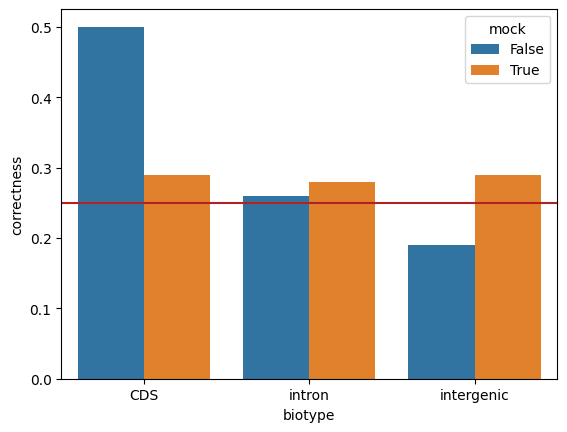

In [61]:
# plot correctness
ax = sns.barplot(data=df_mock, x="biotype", y="correctness", hue="mock")
ax.axhline(y=0.25, color="firebrick")

The generator exhibits verying level of performance on the real sequences. On the mocks, its performance is marginally better than random. There is a strong performance difference in favor of the real sequence in CDS. In introns, both real and mock sequence are approximately random. In the intergenic region, the generator performs very poorly on the real sequence, and hence is worse than the mock. 

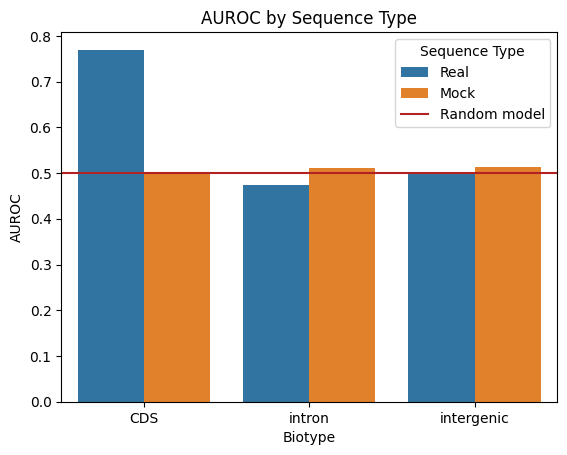

In [101]:
ax = sns.barplot(data=df_mock, x="biotype", y="auroc", hue="mock")
ax.axhline(y=0.5, color="firebrick", label="Random model")
ax.set(xlabel="Biotype", ylabel="AUROC", title="AUROC by Sequence Type")
legend = ax.legend()
legend.set_title("Sequence Type")
legend.get_texts()[0].set_text("Real")
legend.get_texts()[1].set_text("Mock")

The AUROC is only significantly above random in real CDS. In all other cases, it is approximately as good as random.

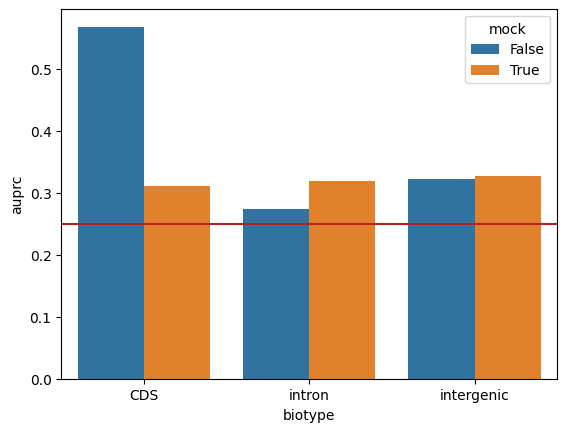

In [63]:
ax = sns.barplot(data=df_mock, x="biotype", y="auprc", hue="mock")
ax.axhline(y=0.25, color="firebrick")

The results are similar to AUROC. However, in this case the intron and intergenic regions are slightly better than random.

In the coding sequence, the model performs significantly better with a real sequence than with a randomly generated one. Importantly, its performance is close to random guesses when given random sequences. With intron and intergenic DNA, the model performs close to random. This is in line with the expectations, as the training data included protein-coding and some regulatory sequences, but no intronic sequences, and no eukaryotic intergenic DNA. Additionally, non-regulatory intergenic DNA can be close to a random sequence.

# Context and generation size

One of the parameters relevant to the generation is the lenght of the context and generated sequence. We will analyze how the model performs with different values for these.

In [80]:
# manually selected parameter values
fit_sizes = [500, 1000, 1500, 2000]
test_sizes = [50, 100, 200]

In [65]:
stats_size = []

In [67]:
# run analysis with each combination
for k_fit in fit_sizes:
    for k_test in test_sizes:
        stats_ij = forward_from_fasta("seqs/cds_1.fa", k_fit, k_test, generator_warm, biotype="CDS", index=0, mock=False, seed=42)
        stats_size.append(stats_ij)

Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
Stopping generation at EOS
S

In [68]:
# check everything was calculated
len(stats_size)

12

In [70]:
# restructure data for plotting
stats_size_corr = pd.DataFrame(stats_size).pivot(index="k_fit", columns="k_test", values="correctness")

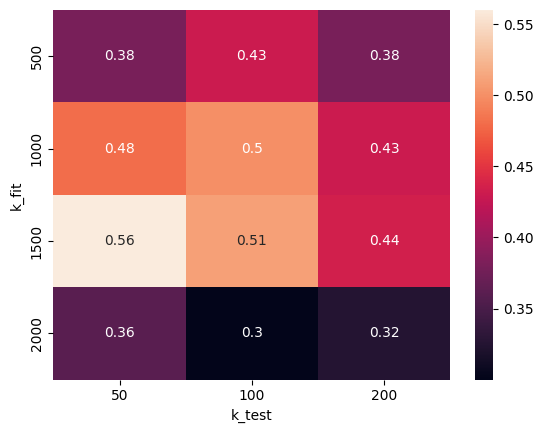

In [72]:
# plot correctness
ax = sns.heatmap(stats_size_corr, annot=True)

In [73]:
# transform with AUROC
stats_size_auroc = pd.DataFrame(stats_size).pivot(index="k_fit", columns="k_test", values="auroc")

Text(50.722222222222214, 0.5, 'Context size')

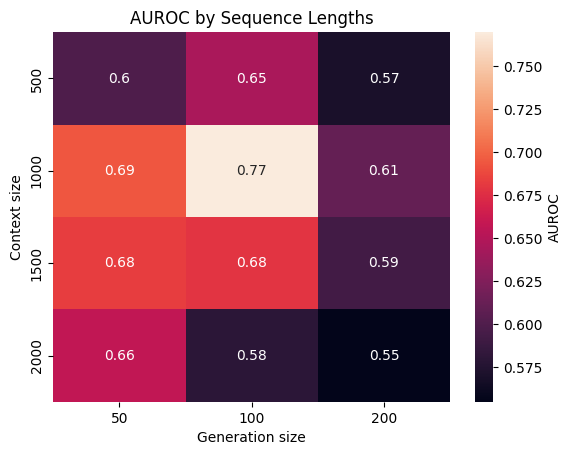

In [102]:
# plot AUROC
ax = sns.heatmap(stats_size_auroc, annot=True, cbar_kws={'label': 'AUROC'})
ax.set_title("AUROC by Sequence Lengths")
ax.set_xlabel("Generation size")
ax.set_ylabel("Context size")

In [75]:
# transform with AUPRC
stats_size_auprc = pd.DataFrame(stats_size).pivot(index="k_fit", columns="k_test", values="auprc")

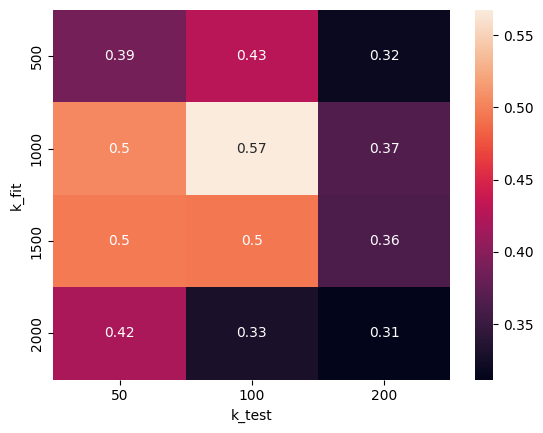

In [76]:
# plot AUPRC
ax = sns.heatmap(stats_size_auprc, annot=True)

We can observe the following:
- With CDS data, the model performs better than random with all context and generation sizes.
- Context size needs to be sufficient to obtain good results. In this scenario, a context of 500 nucleotides is insufficient, but contexts of 1000 and above are good. Beyond 1000, increasing the context further yields little to no improvement.
- The model can provide reasonable results while predicting 50 or 100 nucleotides. However, it becomes quite confused when generating 200 nucleotides, presumably due to error propagation.
- In some cases, the model performs notably better or worse than expected. This is due to the non-zero temperature and the choice of seed (as discussed above). 